#Libraries Import

In [ ]:
import torch
import torchvision.datasets as datasets
import  torchvision.transforms as tt
from random import randint
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm

#Loading data

In [ ]:
train = datasets.MNIST(root='./data',train=True,download=True,transform = tt.ToTensor())
test_ds = datasets.MNIST(root='./data',train=False,download=True,transform = tt.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
test_ds

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

#Test Validation Split

In [ ]:
val_size = int(len(train)*0.2)
train_size = len(train)-val_size

train_ds, val_ds  = torch.utils.data.random_split(train, [train_size,val_size])


print(len(train_ds), len(val_ds))

48000 12000


In [ ]:
batch = 256

#Creating Data Loader 

In [ ]:

train_dl = torch.utils.data.DataLoader ( train_ds,batch, shuffle=True)
val_dl = torch.utils.data.DataLoader ( val_ds,batch, shuffle=True)
test_dl = torch.utils.data.DataLoader ( test_ds,batch, shuffle=True)

#Visualizing training data distributions 

In [ ]:
from collections import Counter
train_class={i:0 for i in range(0,10)}
for _, label in train_dl:
  for j in label:
    train_class[j.item()]+=1



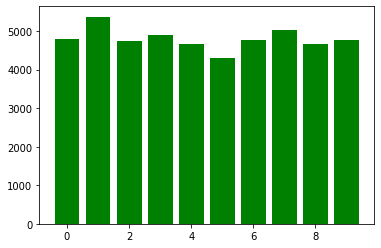

In [ ]:
plt.bar(list(train_class.keys()), train_class.values(), color='g')
plt.show()

#Visualizing Test Data Distribution 

In [ ]:

test_class={i:0 for i in range(10)}
for _, label in test_dl:
  for j in label:
    test_class[j.item()]+=1



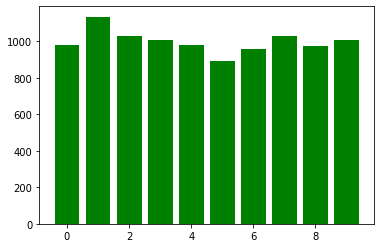

In [ ]:
plt.bar(list(test_class.keys()), test_class.values(), color='g')
plt.show()

In [ ]:
classes = {i:[] for i in range(10)}
for i,j in train_ds:
  classes[j].append(i)

#Visualizing 5 random images of 5 class

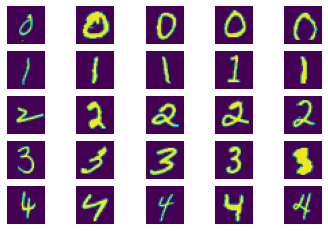

In [ ]:

m=5
n=5
fig, ax = plt.subplots(m,n)
for i in range(m):
  for k in range(n):
    if k==n:
      break
    ax[i][k].imshow(classes[i][randint(0, len(classes[i]))].squeeze(0))
    ax[i][k].axis('off')

plt.show()

#Defining setup 1 backbone architecture 

In [ ]:
class Model(nn.Module):
  def __init__(self,pool=nn.MaxPool2d,active=nn.ReLU):
    super().__init__()

    self.conv1 = nn.Sequential(nn.Conv2d( 1, 10, kernel_size = 5, padding = 1, stride=1),pool(2, 2),active()) #10*13*13

    self.conv2 = nn.Sequential(nn.Conv2d( 10, 20, kernel_size = 2, padding = 0, stride=1),pool(2, 2),active()) #20*7*7
    
    self.flat = nn.Flatten()
    self.n50 = nn.Linear(20*6*6,50)
    self.act = active()
    self.head = nn.Linear(50,10)
    self.final = nn.Softmax()

  def forward(self, x):
    x = self.conv1(x)
    #print(x.shape)
    x = self.conv2(x)
    #print(x.shape)
    x = self.flat(x)
    #print(x.shape)
    x = self.act(x)
    x = self.n50(x)
    x = self.head(x)
    x = self.final(x)
    return x
  def train_step(self,batch):
    
    image , label =  batch
    pred = self(image)
    loss = F.cross_entropy(pred,label)
    
    train_acc = accuracy(pred,label)
    return loss, train_acc
  
  def valid_step(self,batch):
    image , label =  batch
    pred = self(image)
    loss = F.cross_entropy(pred,label)
    val_acc = accuracy(pred,label)
    return {'val_loss':loss.item(), 'val_acc':val_acc}
  






#Defining Setup 2 backbone architecture 

In [ ]:
class RModel(nn.Module):
  def __init__(self,pool=nn.MaxPool2d,active=nn.ReLU):
    super().__init__()

    self.conv1 = nn.Sequential(nn.Conv2d( 1, 10, kernel_size = 5, padding = 1, stride=1),pool(2, 2),active()) #10*13*13

    self.conv2 = nn.Sequential(nn.Conv2d( 10, 20, kernel_size = 2, padding = 8, stride=1),active()) #20*6*6
    
    
    self.pool = pool(2,2)#20*3*3
    self.flat = nn.Flatten()
    self.n50 = nn.Linear(20*14*14,50)
    self.act = active()
    self.head = nn.Linear(50,10)
    self.final = nn.LogSoftmax()
    
    self.train_loss = 0
    

  def forward(self, x):
    residue = x
    x = self.conv1(x)
    x = self.conv2(x)+residue
    x = self.pool(x)
    
    x = self.flat(x)
    
    x = self.act(x)
    
    
    x = self.n50(x)
    x = self.head(x)
    x = self.final(x)
    return x
  def train_step(self,batch):
      
      image , label =  batch
      pred = self(image)
      loss = F.cross_entropy(pred,label)
      
      train_acc = accuracy(pred,label)
      return loss, train_acc
    
  def valid_step(self,batch):
      image , label =  batch
      pred = self(image)
      loss = F.cross_entropy(pred,label)
      val_acc = accuracy(pred,label)
      return {'val_loss':loss.item(), 'val_acc':val_acc}




#Defining utility function 

In [ ]:
@torch.no_grad()
def accuracy(outputs,label):
  _,out = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)

def accumalter(result):
  val_loss = [i['val_loss'] for i in result]
  val_acc = [i['val_acc'] for i in result]
  val_loss = np.mean(val_loss)
  val_acc = np.mean(val_acc)
  return {'val_loss':val_loss, 'val_acc':val_acc}

@torch.no_grad()
def valid_fun(model,val_dl):
  model.eval()
  result = [model.valid_step(i) for i in val_dl]
  return accumalter(result)

def fit(model,train_dl,val_dl,epochs,lr,optim):
  optimizer = optim(model.parameters(),lr=lr)
  history = []
  for epoch in range(epochs):
    train_loss = []
    train_acc = []
    model.train()
    for batch in tqdm(train_dl):
      optimizer.zero_grad()
      loss,acc = model.train_step(batch)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      train_acc.append(acc)
    result = valid_fun(model,val_dl)
    result['train_loss']=np.mean(train_loss)
    result['train_acc']=np.mean(train_acc)
    history.append(result)
    print(f'epoch :{epoch+1}, training loss: {result["train_loss"]},training accuracy: {result["train_acc"]}, validation loss: {result["val_loss"]}, valid accuracy: {result["val_acc"]}')
  return history
    




#Defining plot function 

In [ ]:
def plot_loss(meta):
  val_loss = [i['val_loss'] for i in meta]
  train_loss = [i['train_loss'] for i in meta]
  plt.plot(range(len(meta)),train_loss,label='train_loss')
  plt.plot(range(len(meta)),val_loss,label='validation_loss')
  plt.title("Training loss Vs Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Cross Entopy loss")
  plt.legend()
  plt.show()
def plot_acc(meta):
  val_acc = [i['val_acc'] for i in meta]
  train_acc = [i['train_acc'] for i in meta]
  plt.plot(range(len(meta)),train_acc,label='train_accuracy')
  plt.plot(range(len(meta)),val_acc,label='validation_accuracy')
  plt.title("Training Accuracy Vs Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


# Traning setup 1 on different paramenters

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.5751869069769027,training accuracy: 0.8899393284574468, validation loss: 1.5172034197665276, valid accuracy: 0.9462267287234043


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 1.5019993661565985,training accuracy: 0.9591090425531915, validation loss: 1.4947671027893716, valid accuracy: 0.9672183700607904


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 1.494551253445605,training accuracy: 0.9666098736702128, validation loss: 1.5066100637963478, valid accuracy: 0.9540036094224925


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 1.4923466786425164,training accuracy: 0.9686253324468085, validation loss: 1.506339577918357, valid accuracy: 0.9542766907294833


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 1.4952852028481505,training accuracy: 0.9657787566489362, validation loss: 1.4898620539523186, valid accuracy: 0.97118398556231


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 1.4961080969648157,training accuracy: 0.9649476396276596, validation loss: 1.5038989046786695, valid accuracy: 0.9565919452887538


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 1.4988879231696433,training accuracy: 0.9622257313829787, validation loss: 1.4950297462179305, valid accuracy: 0.965817344224924


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 1.4983624061371417,training accuracy: 0.9627036236702128, validation loss: 1.499282844523166, valid accuracy: 0.9618517287234043


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 1.5024659652659234,training accuracy: 0.9586311502659575, validation loss: 1.492291014245216, valid accuracy: 0.9686431420972644


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 1.5011246508740363,training accuracy: 0.9599609375, validation loss: 1.5084617366182043, valid accuracy: 0.9526619490881458


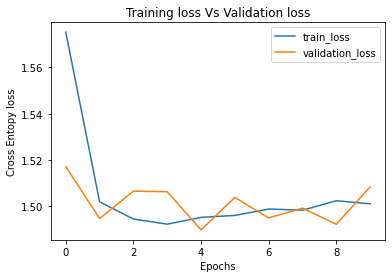

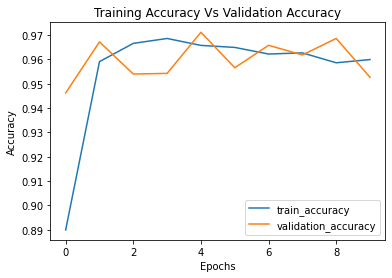

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008

meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model1')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 2.3024673170231758,training accuracy: 0.09840425531914894, validation loss: 2.3021705911514605, valid accuracy: 0.10139627659574468


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 2.3019459425134863,training accuracy: 0.09881981382978723, validation loss: 2.301648845063879, valid accuracy: 0.10142002279635258


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 2.3013983800056135,training accuracy: 0.09867436835106383, validation loss: 2.301098777892742, valid accuracy: 0.10136065729483283


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 2.300807947808124,training accuracy: 0.09873670212765957, validation loss: 2.3004985160016, valid accuracy: 0.10133691109422492


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 2.3001522967155945,training accuracy: 0.09884059175531915, validation loss: 2.299827844538587, valid accuracy: 0.10134878419452886


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 2.2994087046765266,training accuracy: 0.09875748005319149, validation loss: 2.2990463439454425, valid accuracy: 0.10176434270516717


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 2.2985425540741455,training accuracy: 0.1002950465425532, validation loss: 2.2981322014585452, valid accuracy: 0.10664418693009119


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 2.2974922669694777,training accuracy: 0.11905751329787234, validation loss: 2.2970133791578577, valid accuracy: 0.13832161854103342


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 2.2961865650846605,training accuracy: 0.16001080452127658, validation loss: 2.295588285365003, valid accuracy: 0.17768094604863222


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 2.294500837934778,training accuracy: 0.18831033909574468, validation loss: 2.2937245013866017, valid accuracy: 0.18983900075987845


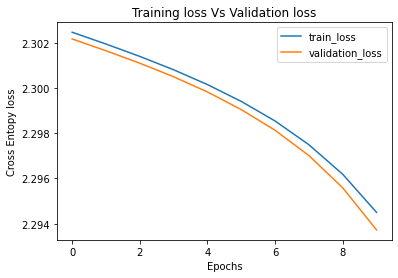

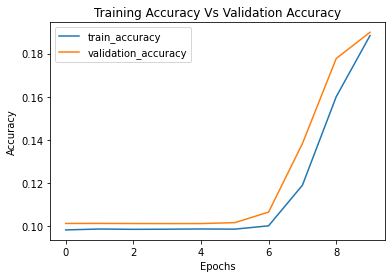

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.SGD

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008

meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model2')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 2.361417907349607,training accuracy: 0.09965093085106383, validation loss: 2.366628900487372, valid accuracy: 0.09452175151975684


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 2.36120882566939,training accuracy: 0.09994182180851063, validation loss: 2.366605155011441, valid accuracy: 0.09454549772036475


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 2.3613958269991775,training accuracy: 0.0997548204787234, validation loss: 2.3666170252130385, valid accuracy: 0.09453362462006078


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 2.3613750490736454,training accuracy: 0.09977559840425532, validation loss: 2.366628900487372, valid accuracy: 0.09452175151975684


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 2.3613334932225816,training accuracy: 0.09981715425531915, validation loss: 2.366747627867029, valid accuracy: 0.09440302051671733


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 2.3613127152970494,training accuracy: 0.09983793218085106, validation loss: 2.366628900487372, valid accuracy: 0.09452175151975684


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 2.3612919373715178,training accuracy: 0.09985871010638298, validation loss: 2.3665457887852446, valid accuracy: 0.0946048632218845


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 2.361416604924709,training accuracy: 0.09973404255319149, validation loss: 2.3666526459633035, valid accuracy: 0.09449800531914894


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 2.361416604924709,training accuracy: 0.09973404255319149, validation loss: 2.3666645161649016, valid accuracy: 0.09448613221884498


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 2.3613542711481137,training accuracy: 0.09979637632978723, validation loss: 2.3666882667135685, valid accuracy: 0.09446238601823709


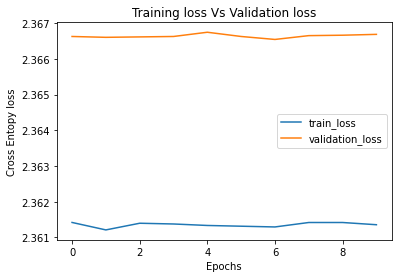

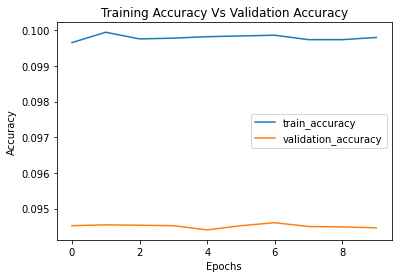

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.RMSprop

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008

meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model3')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.605545496686976,training accuracy: 0.8597490026595744, validation loss: 1.5522296935953992, valid accuracy: 0.9092776405775075


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 1.5434003504032785,training accuracy: 0.9176986369680851, validation loss: 1.540879026372382, valid accuracy: 0.920189019756839


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 1.532241219535787,training accuracy: 0.9285862699468085, validation loss: 1.542617087668561, valid accuracy: 0.9186455167173252


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 1.517915167707078,training accuracy: 0.9431515957446809, validation loss: 1.5120072237988735, valid accuracy: 0.9487675721884499


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 1.5116531379679417,training accuracy: 0.9492810837765957, validation loss: 1.5102446180708864, valid accuracy: 0.9506316489361702


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 1.5085090887039265,training accuracy: 0.9524808843085106, validation loss: 1.5050527313922315, valid accuracy: 0.9559745440729482


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 1.5078833946522245,training accuracy: 0.9531457779255319, validation loss: 1.5061520008330649, valid accuracy: 0.9547159954407295


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 1.5041921189490786,training accuracy: 0.956781914893617, validation loss: 1.5109143536141578, valid accuracy: 0.9503110752279635


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 1.5020374078699883,training accuracy: 0.9591298204787234, validation loss: 1.4993593921052648, valid accuracy: 0.9613411854103344


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 1.5026298805754235,training accuracy: 0.9584649268617021, validation loss: 1.500681976054577, valid accuracy: 0.9604032104863223


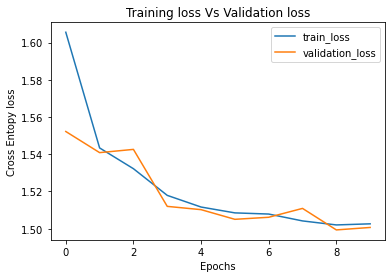

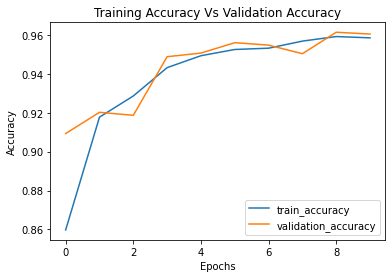

In [ ]:
activation_fn = nn.Tanh
Pooling_fn = nn.AvgPool2d
optim= torch.optim.Adam

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model4')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 2.3028545430366028,training accuracy: 0.08178191489361702, validation loss: 2.302702533437851, valid accuracy: 0.079834726443769


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 2.3024983000248036,training accuracy: 0.0911112034574468, validation loss: 2.3023556242597865, valid accuracy: 0.10152688069908815


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 2.302136610163019,training accuracy: 0.13428773271276595, validation loss: 2.3019956832236432, valid accuracy: 0.16742258738601823


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 2.301764188928807,training accuracy: 0.18292885638297873, validation loss: 2.3016224465471633, valid accuracy: 0.1834156534954407


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 2.3013752711580153,training accuracy: 0.1861078789893617, validation loss: 2.3012327742069325, valid accuracy: 0.18373622720364743


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 2.300964593887329,training accuracy: 0.18648188164893617, validation loss: 2.3008174490421376, valid accuracy: 0.18558843085106383


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 2.3005238809484116,training accuracy: 0.18880900930851063, validation loss: 2.3003723570641053, valid accuracy: 0.1871081876899696


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 2.300044981723136,training accuracy: 0.19009724069148937, validation loss: 2.299878901623665, valid accuracy: 0.1895303001519757


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 2.299525591921299,training accuracy: 0.1922581449468085, validation loss: 2.2993413387460913, valid accuracy: 0.19114504179331304


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 2.298939679531341,training accuracy: 0.19435671542553193, validation loss: 2.2987354664092368, valid accuracy: 0.19414893617021275


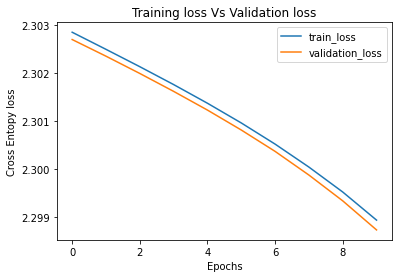

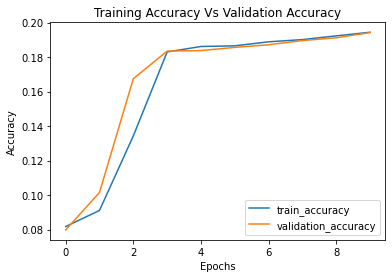

In [ ]:
activation_fn = nn.Tanh
Pooling_fn = nn.AvgPool2d
optim= torch.optim.SGD

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model5')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.6191015376689586,training accuracy: 0.8447057845744681, validation loss: 1.5442841560282605, valid accuracy: 0.9177906534954408


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 1.516156071678121,training accuracy: 0.9461851728723404, validation loss: 1.501879834114237, valid accuracy: 0.9597739361702128


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 1.5030326614988612,training accuracy: 0.9586103723404256, validation loss: 1.4976051995094786, valid accuracy: 0.9640838715805471


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 1.496302176663216,training accuracy: 0.9649891954787234, validation loss: 1.4988066465296643, valid accuracy: 0.962623480243161


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 1.4941546485779134,training accuracy: 0.9668176529255319, validation loss: 1.4937282344128222, valid accuracy: 0.9676695478723404


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 1.4951193408763155,training accuracy: 0.9658410904255319, validation loss: 1.4940569908060926, valid accuracy: 0.9668859232522797


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 1.4929420212481885,training accuracy: 0.968001994680851, validation loss: 1.4998659199856696, valid accuracy: 0.961424297112462


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 1.4935635138065257,training accuracy: 0.9674825465425532, validation loss: 1.4943431539738432, valid accuracy: 0.9666484612462006


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 1.4928488750407036,training accuracy: 0.9681266622340425, validation loss: 1.4959246858637383, valid accuracy: 0.9647962575987842


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 1.4919914514460462,training accuracy: 0.9690201130319149, validation loss: 1.497807167946024, valid accuracy: 0.9635495820668692


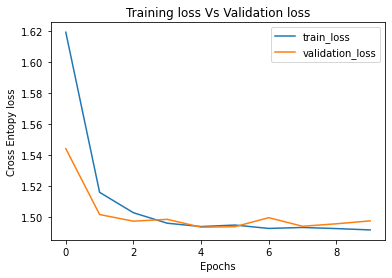

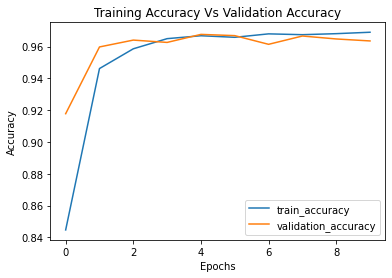

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.AvgPool2d
optim= torch.optim.Adam

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model6')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.5860371894024787,training accuracy: 0.8804230385638298, validation loss: 1.5032695481117735, valid accuracy: 0.9584085296352585


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 1.4983969793674794,training accuracy: 0.9635762965425532, validation loss: 1.4927733730762562, valid accuracy: 0.9686193958966565


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 1.4893173588083146,training accuracy: 0.9722199135638298, validation loss: 1.4881292657649263, valid accuracy: 0.9729412044072948


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 1.486339860140009,training accuracy: 0.9750457114361702, validation loss: 1.4880807044658255, valid accuracy: 0.9732973974164134


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 1.485157938713723,training accuracy: 0.9760430518617021, validation loss: 1.4879036786708426, valid accuracy: 0.9731786664133738


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 1.4848180210336726,training accuracy: 0.9764793882978723, validation loss: 1.4854277296269194, valid accuracy: 0.975327697568389


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 1.4841575064557664,training accuracy: 0.9771650598404256, validation loss: 1.4857101896975904, valid accuracy: 0.9754108092705167


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 1.4858904969184956,training accuracy: 0.9751911569148937, validation loss: 1.487848127141912, valid accuracy: 0.9732499050151976


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 1.4867079086760258,training accuracy: 0.9742977061170213, validation loss: 1.496001347582391, valid accuracy: 0.9651999430091185


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 1.4866900780099503,training accuracy: 0.9745678191489362, validation loss: 1.4869262132238834, valid accuracy: 0.9739741641337386


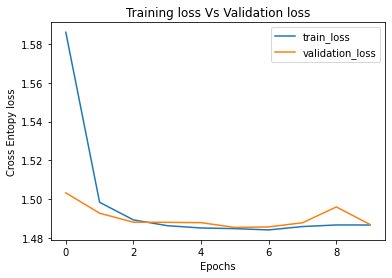

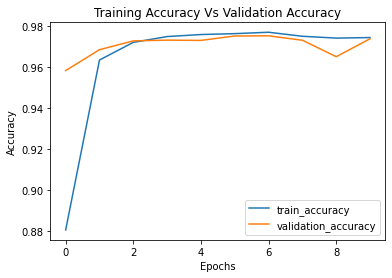

In [ ]:
activation_fn = nn.Tanh
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model7')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 2.360711154785562,training accuracy: 0.1002950465425532, validation loss: 2.3622595959521355, valid accuracy: 0.09889105243161095


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 2.361790607584284,training accuracy: 0.09936003989361702, validation loss: 2.362318962178332, valid accuracy: 0.09883168693009119


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 2.3618529413608793,training accuracy: 0.09929770611702128, validation loss: 2.362342707654263, valid accuracy: 0.09880794072948329


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 2.3619152751374752,training accuracy: 0.09923537234042554, validation loss: 2.362271471226469, valid accuracy: 0.098879179331307


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 2.3618529413608793,training accuracy: 0.09929770611702128, validation loss: 2.362318962178332, valid accuracy: 0.09883168693009119


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 2.361894497211943,training accuracy: 0.09925615026595745, validation loss: 2.3622952167024005, valid accuracy: 0.09885543313069908


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 2.362019164765135,training accuracy: 0.09913148271276596, validation loss: 2.362342707654263, valid accuracy: 0.09880794072948329


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 2.3619152751374752,training accuracy: 0.09923537234042554, validation loss: 2.362318962178332, valid accuracy: 0.09883168693009119


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 2.3618529413608793,training accuracy: 0.09929770611702128, validation loss: 2.3623070919767337, valid accuracy: 0.09884356003039513


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 2.3619152751374752,training accuracy: 0.09923537234042554, validation loss: 2.3622952167024005, valid accuracy: 0.09885543313069908


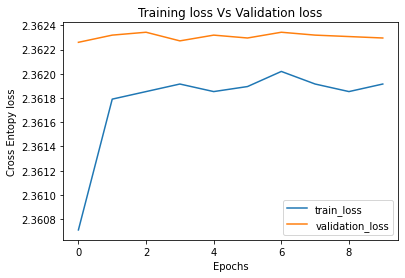

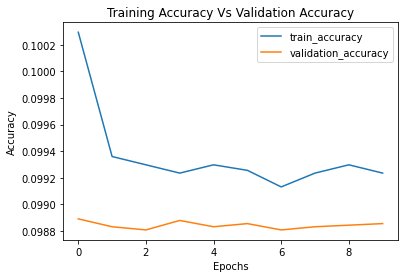

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.1

meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model8')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-120-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-122-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 2.2559611404195743,training accuracy: 0.2077169215425532, validation loss: 2.1150744722244585, valid accuracy: 0.45680566109422494


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 1.903073417379501,training accuracy: 0.6446351396276596, validation loss: 1.7946278364100354, valid accuracy: 0.7144400645896656


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 1.7590052656670834,training accuracy: 0.7353307845744681, validation loss: 1.7431373621555084, valid accuracy: 0.7396585296352585


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 1.7281965347046548,training accuracy: 0.7491481050531915, validation loss: 1.7257903307042224, valid accuracy: 0.7482309080547113


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 1.715668502640217,training accuracy: 0.7542594747340425, validation loss: 1.7169602424540418, valid accuracy: 0.752220269756839


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 1.7084873293308502,training accuracy: 0.7591422872340425, validation loss: 1.7108407959024956, valid accuracy: 0.7559128039513677


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 1.7036159723363025,training accuracy: 0.7618641954787234, validation loss: 1.707436447447919, valid accuracy: 0.7573494490881458


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 1.7000301055451656,training accuracy: 0.7645653257978723, validation loss: 1.7042315158438175, valid accuracy: 0.7599377849544073


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 1.6969476805088368,training accuracy: 0.7662067819148937, validation loss: 1.7009406115146393, valid accuracy: 0.7624073898176291


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 1.6945284230911986,training accuracy: 0.7683884640957447, validation loss: 1.6991854703172724, valid accuracy: 0.7630129179331308


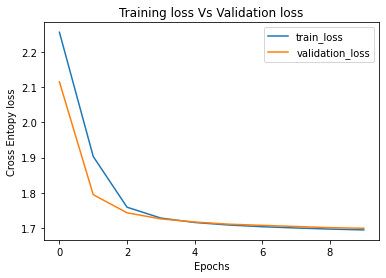

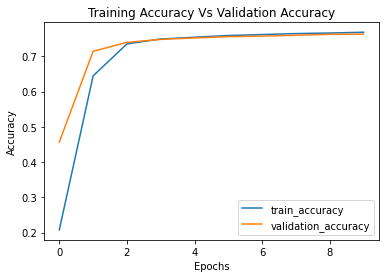

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  Model(Pooling_fn,activation_fn)
epochs=10
lr=0.0001

meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model9')

#Traning Setup-2 on different parameters

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-42-62858c4f711f>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-9-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 0.602931870583524,training accuracy: 0.8549285239361702, validation loss: 0.34581338281327106, valid accuracy: 0.8963003419452887


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.35073745242775756,training accuracy: 0.8963804853723404, validation loss: 0.3754234580283469, valid accuracy: 0.8873005319148937


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.3522915247272938,training accuracy: 0.896235039893617, validation loss: 0.3509433738728787, valid accuracy: 0.8991023936170213


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.3574239568824464,training accuracy: 0.8960688164893617, validation loss: 0.36237068062132977, valid accuracy: 0.8970246010638298


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.3556878240977196,training accuracy: 0.8972947140957447, validation loss: 0.36084436736208325, valid accuracy: 0.8940681990881458


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.3582893651216588,training accuracy: 0.8960480385638298, validation loss: 0.41416620066825377, valid accuracy: 0.8711412424012158


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.3619089291450825,training accuracy: 0.8946143617021277, validation loss: 0.3699534833431244, valid accuracy: 0.885032769756839


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.3541250697317276,training accuracy: 0.897232380319149, validation loss: 0.36311645774131124, valid accuracy: 0.8974757788753799


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.3561714070432998,training accuracy: 0.8949468085106383, validation loss: 0.39568567910092944, valid accuracy: 0.8866712575987842


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.3501394014567771,training accuracy: 0.897710272606383, validation loss: 0.3845110754383371, valid accuracy: 0.8932489551671733


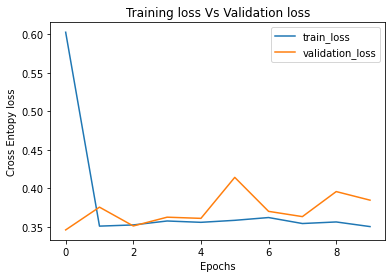

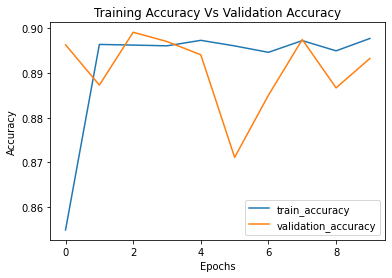

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model10')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-42-62858c4f711f>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-9-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.3033923335531925,training accuracy: 0.732172539893617, validation loss: 0.7815037293637053, valid accuracy: 0.8247530395136777


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.6307824452189689,training accuracy: 0.8492769281914894, validation loss: 0.542445736996671, valid accuracy: 0.8610253609422492


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.49197717724328344,training accuracy: 0.8692237367021277, validation loss: 0.46206927362908706, valid accuracy: 0.8723997910334347


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.4354889605273592,training accuracy: 0.8789893617021277, validation loss: 0.42361860706451093, valid accuracy: 0.8792624430091185


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.40445536818910155,training accuracy: 0.885513630319149, validation loss: 0.39937760538243233, valid accuracy: 0.8864812879939209


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.38380672909477925,training accuracy: 0.8900432180851063, validation loss: 0.3822779509615391, valid accuracy: 0.8888559080547113


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.36927194726910995,training accuracy: 0.8935131316489362, validation loss: 0.3706244255634064, valid accuracy: 0.8916817059270518


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.3578005052627401,training accuracy: 0.8961727061170213, validation loss: 0.3602704833796684, valid accuracy: 0.8939732142857142


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.3485626075020496,training accuracy: 0.8978557180851063, validation loss: 0.3516038751348536, valid accuracy: 0.8953623670212766


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.3405509249485554,training accuracy: 0.9004945146276596, validation loss: 0.345364012616746, valid accuracy: 0.8958729103343465


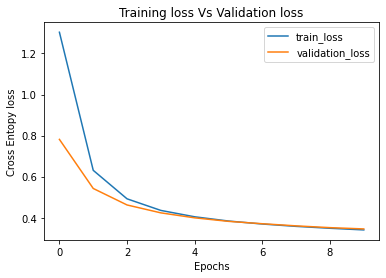

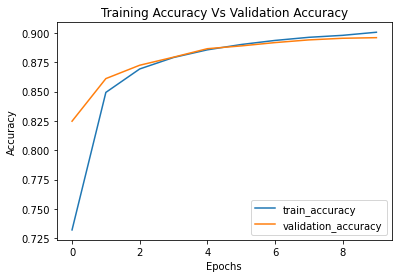

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.SGD

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model11')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-42-62858c4f711f>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-9-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 0.42360307981676243,training accuracy: 0.8751246675531915, validation loss: 0.310500886212004, valid accuracy: 0.9083871580547113


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.2604177112671289,training accuracy: 0.9262175864361702, validation loss: 0.2015669899100953, valid accuracy: 0.9400408434650457


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.17430371981351933,training accuracy: 0.9490317486702128, validation loss: 0.1448980227429816, valid accuracy: 0.9579336056231004


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.13872488084784212,training accuracy: 0.9589428191489362, validation loss: 0.12324040319691314, valid accuracy: 0.9630152925531915


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.10901975798163008,training accuracy: 0.9672332114361702, validation loss: 0.11744935382553871, valid accuracy: 0.9663753799392096


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.10214761354306594,training accuracy: 0.9691863364361702, validation loss: 0.12037724747936776, valid accuracy: 0.9675864361702128


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.09040969786571061,training accuracy: 0.9729263630319149, validation loss: 0.09244700616344492, valid accuracy: 0.9730005699088146


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.08313626377902766,training accuracy: 0.9742353723404256, validation loss: 0.09423987674427793, valid accuracy: 0.9741997530395138


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.07712901713068973,training accuracy: 0.976333942819149, validation loss: 0.10867290579258128, valid accuracy: 0.9684650455927052


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.08230221003016576,training accuracy: 0.9751496010638298, validation loss: 0.11672126256087993, valid accuracy: 0.969984802431611


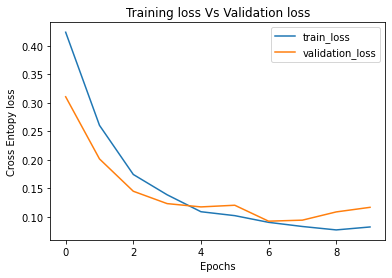

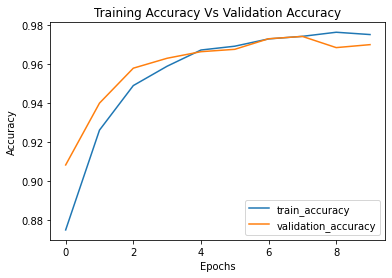

In [ ]:
activation_fn = nn.Tanh
Pooling_fn = nn.AvgPool2d
optim= torch.optim.Adam

model =   RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model12')

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-42-62858c4f711f>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-9-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.7077103770793753,training accuracy: 0.655044880319149, validation loss: 1.200188768670914, valid accuracy: 0.7670497720364742


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.9316078608340406,training accuracy: 0.8032746010638298, validation loss: 0.7507224869220814, valid accuracy: 0.8309033054711246


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.6505179481303438,training accuracy: 0.8462849069148937, validation loss: 0.5833231337527012, valid accuracy: 0.8590188069908815


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.5320478400334399,training accuracy: 0.8678731715425532, validation loss: 0.5010195666171134, valid accuracy: 0.8716042933130699


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.46952023436414436,training accuracy: 0.8775764627659575, validation loss: 0.45356023057978206, valid accuracy: 0.8807109612462006


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.43153950603718455,training accuracy: 0.8829995013297872, validation loss: 0.42330668581292985, valid accuracy: 0.8856145516717325


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.40638512135186095,training accuracy: 0.8873420877659575, validation loss: 0.40313322873825724, valid accuracy: 0.8895089285714286


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.3887982870987121,training accuracy: 0.890874335106383, validation loss: 0.38782025968774836, valid accuracy: 0.890363791793313


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.3757783792754437,training accuracy: 0.893076795212766, validation loss: 0.37654815328882096, valid accuracy: 0.8944956306990882


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.3659669766400723,training accuracy: 0.8953415890957447, validation loss: 0.36782075115974916, valid accuracy: 0.8967871390577508


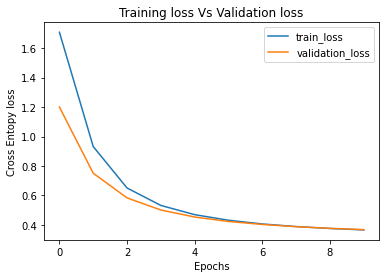

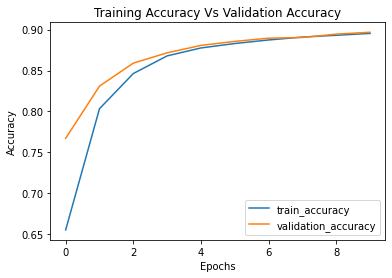

In [ ]:
activation_fn = nn.Tanh
Pooling_fn = nn.AvgPool2d
optim= torch.optim.SGD

model =   RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model13')

In [ ]:
for k in range(1,14):
  
  if k<10:
    model = Model()
  else:
    model = RModel()  
  model.load_state_dict(torch.load('/content/model'+str(k)))
  model.eval()
  acc= 0
  for i,j in test_dl:
    pred = model(i)
    acc += accuracy(pred,j)
  print(f'accuracy for model {k}  on test set is {acc/len(test_dl)}')



<ipython-input-50-fed68fd88695>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-9-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


accuracy for model 1  on test set is 0.95751953125
accuracy for model 2  on test set is 0.1921875
accuracy for model 3  on test set is 0.09716796875
accuracy for model 4  on test set is 0.3720703125
accuracy for model 5  on test set is 0.1224609375
accuracy for model 6  on test set is 0.95625
accuracy for model 7  on test set is 0.2869140625
accuracy for model 8  on test set is 0.1
accuracy for model 9  on test set is 0.7728515625


<ipython-input-42-62858c4f711f>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)


accuracy for model 10  on test set is 0.8998046875
accuracy for model 11  on test set is 0.910546875
accuracy for model 12  on test set is 0.10849609375
accuracy for model 13  on test set is 0.7162109375
